## QUERY

In [1]:
# usage example (the mysql detail already defined)
# simple query
query_order_garden = """
SELECT
  order_garden.id_order AS id_order_garden,
  order_garden.id_user,
  order_garden.id_gardener,
  order_garden.status AS status_garden,
  promo_code.code ,
  order_garden.size_area,
  order_garden.address,
  address_components.address_componentable_id ,
  CAST(address_components.latitude AS FLOAT) AS lat,
  CAST(address_components.longitude AS FLOAT) AS lng,
  order_garden.created_at AS order_date
FROM
  order_garden
  JOIN address_components ON order_garden.id_order = address_components.address_componentable_id
  LEFT JOIN promo_code ON order_garden.id_promo = promo_code.id_promo
  JOIN user ON order_garden.id_user = user.id_user
WHERE
   (
    (order_garden.status <> 'expired')
    OR (order_garden.status IS NULL)
  ) AND address_components.address_componentable_type LIKE '%OrderGarden'
GROUP BY
  order_garden.id_order,
  order_garden.status,
  order_garden.id_user,
  order_garden.id_gardener,
  order_garden.id_promo,
  order_garden.size_area,
  order_garden.address,
  address_components.address_componentable_id ,
  address_components.latitude,
  address_components.longitude,
  order_garden.created_at

"""

## Import Function

In [2]:
from functions.database_load import *
from functions.cleaning import * 
from functions.utils import *
from functions.clustering import *
from functions.neighbors import *
from functions.visualization import *

#### Reload/ update function

In [3]:
# from importlib import reload
# import functions.utils
# reload(functions.utils)

## Mengambil Data Order Garden

In [4]:
# fetch data
df_og = fetch_data(query_order_garden)

In [5]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_order_garden           92 non-null     int64         
 1   id_user                   92 non-null     int64         
 2   id_gardener               88 non-null     float64       
 3   status_garden             92 non-null     object        
 4   code                      24 non-null     object        
 5   size_area                 92 non-null     float64       
 6   address                   92 non-null     object        
 7   address_componentable_id  92 non-null     int64         
 8   lat                       92 non-null     float64       
 9   lng                       92 non-null     float64       
 10  order_date                92 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 8.0+ KB


### Menghapus data id yang tidak terpakai 

In [7]:
#  menghapus id yang tidak terpakai untuk analisis
ids_to_remove= [150,113,110]
df_og_new = remove_ids_from_dataframe(df_og, column_name="id_order_garden", ids_to_remove=ids_to_remove)

## Missing Values

In [8]:
#  cek missing values
cek_missing_values(df_og_new)

id_order_garden              0
id_user                      0
id_gardener                  4
status_garden                0
code                        65
size_area                    0
address                      0
address_componentable_id     0
lat                          0
lng                          0
order_date                   0
dtype: int64

In [9]:
# input code promo yang null dengan nilai N/A
fill_missing_values(df_og_new, column_name="code", fill_value="N/A").head()

,id_order_garden,id_user,id_gardener,status_garden,code,size_area,address,address_componentable_id,lat,lng,order_date
0,65,927,1087.0,in_review,N/A,11.0,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,65,-6.29776,106.862,2024-04-23 16:05:27
1,66,926,1093.0,in_review,N/A,28.0,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",66,-6.26076,106.690,2024-04-27 12:19:36
2,70,925,1085.0,finish,N/A,35.0,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",70,-6.32984,106.876,2024-05-16 17:59:26
3,72,1024,1087.0,finish,N/A,2.0,"Bekasi, Kota Bekasi, Jawa Barat",72,-6.23827,106.976,2024-05-24 06:24:44
4,74,1052,1087.0,finish,potongandeposit01,5.0,"Wakay Residences, no A7, Jl. Abdulrahman, RT.1...",74,-6.36347,106.880,2024-06-12 08:40:53


In [11]:
#  preprocess data (drop missing values)
df_og_clean=preprocess_data(df_og_new)

In [12]:
# Split numeric and object data
df_og_num = df_og_clean.select_dtypes(include=['int64', 'float64'])

In [13]:
# find outliers
for col in df_og_num:
        values = df_og_num[col].sort_values().values.tolist()
        outliers = find_outlier(values)
        outlier_count = len(outliers.split(', ')) - 1  # Split string and count
        outlier_percent = (outlier_count / len(values)) * 100
        print(f"Outliers detected in '{col}': {outlier_count} ({outlier_percent:.2f}%)")

Outliers detected in 'id_order_garden': 0 (0.00%)
Outliers detected in 'id_user': 0 (0.00%)
Outliers detected in 'id_gardener': 1 (1.18%)
Outliers detected in 'size_area': 10 (11.76%)
Outliers detected in 'address_componentable_id': 0 (0.00%)
Outliers detected in 'lat': 3 (3.53%)
Outliers detected in 'lng': 0 (0.00%)


## Clustering Order Garden

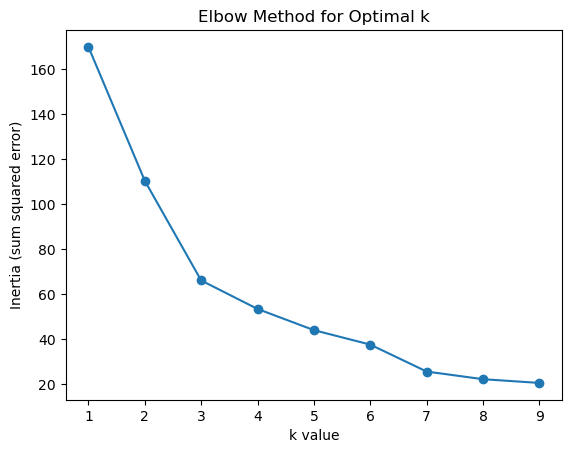

Inertia values for k=1 to 9: [170.0, 110.43603980318238, 66.09899234904317, 53.43588946969419, 44.001757669255035, 37.57193065011684, 25.58695564083075, 22.18062179969965, 20.523017936201946]


In [14]:
# tentukan kolom untuk cluster
feature_cols = ['lat', 'lng']
# Hitung inertia
inertia_values = calculate_inertia(df_og_clean, feature_cols)

# print inertia
print("Inertia values for k=1 to 9:", inertia_values)

In [15]:
# menentukan cluster dan menambahkan kolom cluster pada data order garden care
perform_clustering(df_og_clean, feature_cols, n_clusters=6, max_iter=1000)

,id_order_garden,id_user,id_gardener,status_garden,code,size_area,address,address_componentable_id,lat,lng,order_date,cluster
0,65,927,1087.0,in_review,N/A,11.0,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,65,-6.29776,106.862,2024-04-23 16:05:27,5
1,66,926,1093.0,in_review,N/A,28.0,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",66,-6.26076,106.690,2024-04-27 12:19:36,4
2,70,925,1085.0,finish,N/A,35.0,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",70,-6.32984,106.876,2024-05-16 17:59:26,5
3,72,1024,1087.0,finish,N/A,2.0,"Bekasi, Kota Bekasi, Jawa Barat",72,-6.23827,106.976,2024-05-24 06:24:44,5
4,74,1052,1087.0,finish,potongandeposit01,5.0,"Wakay Residences, no A7, Jl. Abdulrahman, RT.1...",74,-6.36347,106.880,2024-06-12 08:40:53,2
...,...,...,...,...,...,...,...,...,...,...,...,...
86,190,1707,1093.0,finish,N/A,16.0,"Serenia Hills, Jl. Venture Barat no 32, Tanger...",190,-6.25542,106.724,2024-10-28 07:35:51,4
87,191,1607,1093.0,finish,N/A,8.0,cluster Alicante Granada blok ABB no.27 Gading...,191,-6.29943,106.668,2024-10-28 07:37:28,4
88,192,1727,1092.0,acc_gardener,N/A,8.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",192,-6.25731,106.804,2024-10-28 17:04:03,3
89,194,1727,1092.0,finish,N/A,10.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",194,-6.25731,106.804,2024-11-01 20:08:05,3


In [16]:
# visualization map 
calculate_nearest_neighbors(
    df_og_clean,
    lat_col='lat',        # Nama kolom latitude
    lng_col='lng',        # Nama kolom longitude
    id_col='id_order_garden',          # Nama kolom ID unik
    n_neighbors=3,        # Jumlah tetangga terdekat
    max_distance=10000    # Jarak maksimum dalam meter
)

,id_order_garden,id_user,id_gardener,status_garden,code,size_area,address,address_componentable_id,lat,lng,order_date,cluster,neighbors,neighbor_distances,valid_neighbors,valid_distances
0,65,927,1087.0,in_review,N/A,11.0,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,65,-6.29776,106.862,2024-04-23 16:05:27,5,"[65, 116, 183]","[0.0, 0.021464240028476186, 0.02914463243891996]","[65, 116, 183]","[0.0, 2375.0149611740835, 3223.6245242871646]"
1,66,926,1093.0,in_review,N/A,28.0,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",66,-6.26076,106.690,2024-04-27 12:19:36,4,"[66, 81, 104]","[0.0, 0.008526576100635307, 0.021270270332086356]","[66, 81, 104]","[0.0, 943.4743886329433, 2353.721237571324]"
2,70,925,1085.0,finish,N/A,35.0,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",70,-6.32984,106.876,2024-05-16 17:59:26,5,"[70, 74, 65]","[0.0, 0.03386704740599568, 0.03500180566771175]","[70, 74, 65]","[0.0, 3745.309286065119, 3871.1113548546737]"
3,72,1024,1087.0,finish,N/A,2.0,"Bekasi, Kota Bekasi, Jawa Barat",72,-6.23827,106.976,2024-05-24 06:24:44,5,"[72, 123, 111]","[0.0, 0.0, 0.017669773626167787]","[72, 123, 111]","[0.0, 0.0, 1954.695088865319]"
4,74,1052,1087.0,finish,potongandeposit01,5.0,"Wakay Residences, no A7, Jl. Abdulrahman, RT.1...",74,-6.36347,106.880,2024-06-12 08:40:53,2,"[74, 92, 171]","[0.0, 0.015778517040583907, 0.025098334606096888]","[74, 92, 171]","[0.0, 1745.1645581186592, 2776.517031211267]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,190,1707,1093.0,finish,N/A,16.0,"Serenia Hills, Jl. Venture Barat no 32, Tanger...",190,-6.25542,106.724,2024-10-28 07:35:51,4,"[190, 160, 81]","[0.0, 0.020955801106129792, 0.027289633562958274]","[190, 160, 81]","[0.0, 2318.7333393227677, 3019.693818568266]"
87,191,1607,1093.0,finish,N/A,8.0,cluster Alicante Granada blok ABB no.27 Gading...,191,-6.29943,106.668,2024-10-28 07:37:28,4,"[191, 182, 168]","[0.0, 0.014528320618709824, 0.014866068747321977]","[191, 182, 168]","[0.0, 1606.6704481291497, 1644.1093577437396]"
88,192,1727,1092.0,acc_gardener,N/A,8.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",192,-6.25731,106.804,2024-10-28 17:04:03,3,"[194, 192, 154]","[0.0, 0.0, 0.03190235101054779]","[194, 192, 154]","[0.0, 0.0, 3528.609886146801]"
89,194,1727,1092.0,finish,N/A,10.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",194,-6.25731,106.804,2024-11-01 20:08:05,3,"[194, 192, 154]","[0.0, 0.0, 0.03190235101054779]","[194, 192, 154]","[0.0, 0.0, 3528.609886146801]"


## Analisis dan Visualization

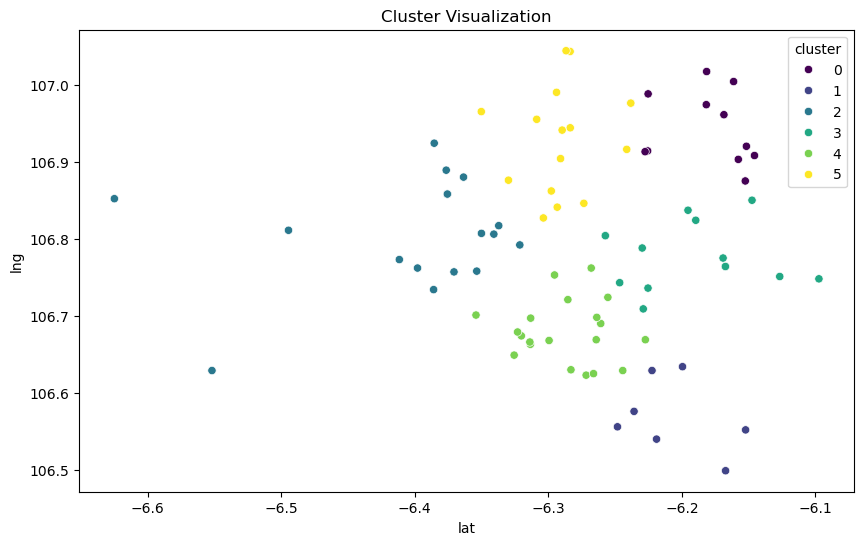

In [17]:
# Visualization cluster menggunakan scater plot
visualize_clusters(
    data=df_og_clean, 
    x_col= 'lat',
    y_col= 'lng', 
    cluster_col="cluster")

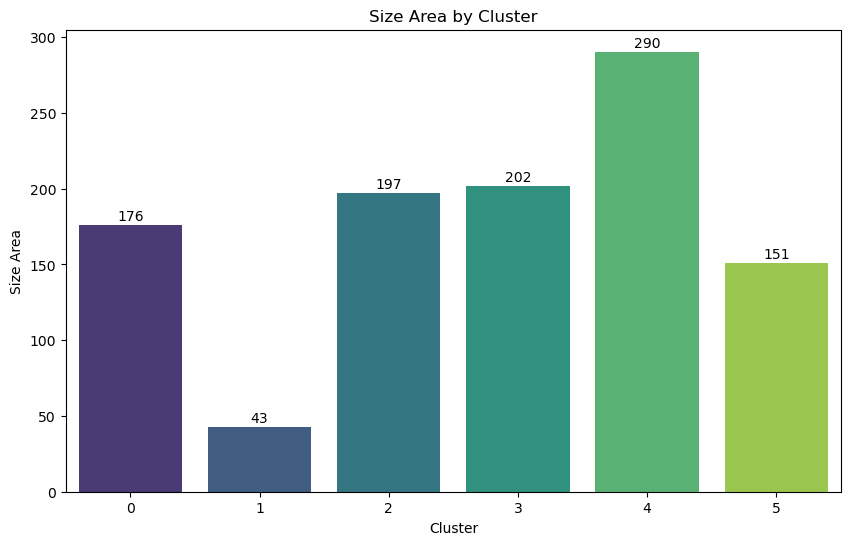

In [18]:
# Luas Taman yang Banyak Dipesan Berdasarkan Cluster
garden_size_per_cluster = df_og_clean.groupby('cluster')['size_area'].sum().reset_index()
garden_size_per_cluster = garden_size_per_cluster.sort_values(by='size_area', ascending=False)

barplot_visualization(
    data=garden_size_per_cluster, 
    x_col='cluster', 
    y_col='size_area',
    title='Size Area by Cluster',
    xlabel='Cluster',
    ylabel='Size Area'
)

In [19]:
# Visualization map berdasarkan cluster dan neighbors
create_cluster_map(
        data = df_og_clean,
       cluster_col = 'cluster', 
       id_col = 'id_order_garden', 
       lat_col= 'lat', 
       lng_col= 'lng', 
       neighbors_col = 'neighbors', 
       distances_col = 'valid_distances', 
       address_col= 'address'
                  )

In [20]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(0, 'Bekasi & Sekitarnya')

In [21]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(1, 'Depok & Sekitarnya')

In [22]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(2, 'Tangerang & Sekitarnya')

In [23]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(3, 'Jakarta Timur & Sekitarnya')

In [24]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(4, 'Tangerang Selatan & Sekitarnya')

In [25]:
df_og_clean['cluster'] = df_og_clean['cluster'].replace(5, 'Jakarta Barat & Sekitarnya')

In [26]:
df_og_clean.to_csv("result/order_garden_clustering_new.csv", index = False )

In [27]:
df_og_clean

,id_order_garden,id_user,id_gardener,status_garden,code,size_area,address,address_componentable_id,lat,lng,order_date,cluster,neighbors,neighbor_distances,valid_neighbors,valid_distances
0,65,927,1087.0,in_review,N/A,11.0,Jl. Ujung Gedong RT 002 RW 012 no.69 Kel. Gedo...,65,-6.29776,106.862,2024-04-23 16:05:27,Jakarta Barat & Sekitarnya,"[65, 116, 183]","[0.0, 0.021464240028476186, 0.02914463243891996]","[65, 116, 183]","[0.0, 2375.0149611740835, 3223.6245242871646]"
1,66,926,1093.0,in_review,N/A,28.0,"Mahagoni Park Bintaro Blok B1 No 50, Perigi Ba...",66,-6.26076,106.690,2024-04-27 12:19:36,Tangerang Selatan & Sekitarnya,"[66, 81, 104]","[0.0, 0.008526576100635307, 0.021270270332086356]","[66, 81, 104]","[0.0, 943.4743886329433, 2353.721237571324]"
2,70,925,1085.0,finish,N/A,35.0,"Premier Terrace Blok M3, Jalan Raya Ciracas, C...",70,-6.32984,106.876,2024-05-16 17:59:26,Jakarta Barat & Sekitarnya,"[70, 74, 65]","[0.0, 0.03386704740599568, 0.03500180566771175]","[70, 74, 65]","[0.0, 3745.309286065119, 3871.1113548546737]"
3,72,1024,1087.0,finish,N/A,2.0,"Bekasi, Kota Bekasi, Jawa Barat",72,-6.23827,106.976,2024-05-24 06:24:44,Jakarta Barat & Sekitarnya,"[72, 123, 111]","[0.0, 0.0, 0.017669773626167787]","[72, 123, 111]","[0.0, 0.0, 1954.695088865319]"
4,74,1052,1087.0,finish,potongandeposit01,5.0,"Wakay Residences, no A7, Jl. Abdulrahman, RT.1...",74,-6.36347,106.880,2024-06-12 08:40:53,Tangerang & Sekitarnya,"[74, 92, 171]","[0.0, 0.015778517040583907, 0.025098334606096888]","[74, 92, 171]","[0.0, 1745.1645581186592, 2776.517031211267]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,190,1707,1093.0,finish,N/A,16.0,"Serenia Hills, Jl. Venture Barat no 32, Tanger...",190,-6.25542,106.724,2024-10-28 07:35:51,Tangerang Selatan & Sekitarnya,"[190, 160, 81]","[0.0, 0.020955801106129792, 0.027289633562958274]","[190, 160, 81]","[0.0, 2318.7333393227677, 3019.693818568266]"
87,191,1607,1093.0,finish,N/A,8.0,cluster Alicante Granada blok ABB no.27 Gading...,191,-6.29943,106.668,2024-10-28 07:37:28,Tangerang Selatan & Sekitarnya,"[191, 182, 168]","[0.0, 0.014528320618709824, 0.014866068747321977]","[191, 182, 168]","[0.0, 1606.6704481291497, 1644.1093577437396]"
88,192,1727,1092.0,acc_gardener,N/A,8.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",192,-6.25731,106.804,2024-10-28 17:04:03,Jakarta Timur & Sekitarnya,"[194, 192, 154]","[0.0, 0.0, 0.03190235101054779]","[194, 192, 154]","[0.0, 0.0, 3528.609886146801]"
89,194,1727,1092.0,finish,N/A,10.0,"Jl. Darmawangsa X No. 69A, Kebayoran Baru, Jak...",194,-6.25731,106.804,2024-11-01 20:08:05,Jakarta Timur & Sekitarnya,"[194, 192, 154]","[0.0, 0.0, 0.03190235101054779]","[194, 192, 154]","[0.0, 0.0, 3528.609886146801]"
